In [1506]:
import random
import numpy as np

random.seed(42)
np.random.seed(42)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pymdp
from pymdp import utils

# Utilities

In [1507]:
def noisy_Id(n, noise, decay=3):

    I = np.eye(n)
    for i in range(n):
        for j in range(n):
            if i != j:
                I[i, j] = (noise / n) * np.exp(-abs(i - j) / decay)
    I /= I.sum(axis=0, keepdims=True)
    return I

In [1508]:
def gain(market_price, prod_cost, Production):
    profit_production = np.array([x for x in Production if isinstance(x, (int, float))])
    if profit_production.size == 0:  # Ensure Production has valid numeric elements
        return np.array([])  # Return an empty array if no valid data

    n_sells = max(profit_production)
    C_gain = (market_price - prod_cost) * profit_production - np.maximum(0, (profit_production - n_sells)) * market_price
    
    # # Add the mean value as the last element
    # C_gain = np.append(C_gain, np.mean(C_gain))  
    
    return C_gain

In [1509]:
def real_gain(market_price, prod_cost, n_sells, Production):
    C_gain = (market_price-prod_cost)*Production - np.maximum(0,(Production-n_sells))*market_price
    return C_gain

In [1510]:
def gain_SRP(SRP_model, prod_cost, n_sells, Production, sales_competitor):
    # Assume Production is a numpy array of production levels
    profit_production = np.array([x for x in Production if isinstance(x, (int, float))])
    gains = []
    for prod in profit_production:
        # Create a feature dictionary for each instance.
        # Adjust the key names according to your feature naming.
        instance = {
            'prod_1': prod,
            'prod_2': sales_competitor,
        }
        # Predict the market price for this instance.
        predicted_price = SRP_model.predict_one(instance)
        # Compute the gain for this production level.
        c_gain = (predicted_price - prod_cost) * prod - np.maximum(0, (prod - n_sells)) * predicted_price #!!!!
        gains.append(c_gain)
    # # Add a last element containing the mean of the previously computed elements
    # if gains:  # Ensure the list is not empty before computing the mean
    #     gains.append(np.mean(gains))
    return np.array(gains)

In [1511]:
from river.metrics.base import Metrics
from river.metrics import RMSE
from river.preprocessing import StandardScaler
from river.drift import ADWIN
from river.ensemble import SRPRegressor
from river.tree import HoeffdingTreeRegressor

SRP_1 = (StandardScaler() |
        SRPRegressor(
            n_models=10,
            seed=1,
            drift_detector=ADWIN(delta=0.001),
            warning_detector=ADWIN(delta=0.01),
            model = HoeffdingTreeRegressor(
                grace_period=50,
                leaf_prediction='adaptive',
                model_selector_decay=0.9,                
            )            
        ))

SRP_2 = (StandardScaler() |
        SRPRegressor(
            n_models=10,
            seed=1,
            drift_detector=ADWIN(delta=0.001),
            warning_detector=ADWIN(delta=0.01),
            model = HoeffdingTreeRegressor(
                grace_period=50,
                leaf_prediction='adaptive',
                model_selector_decay=0.9,                
            )            
        ))

In [1512]:
def get_most_probable_indices(qs):
    return [np.argmax(q) for q in qs]

# O, S, U

In [1513]:
n_action = 10

#States (how much I think I can sell)
state_sales_1 = np.arange(0, n_action)
state_sales_2 = np.arange(0, n_action)

#Other's states
other_state_1 = np.arange(0, n_action)
other_state_2 = np.arange(0, n_action)

# Market states (if I have produced enaugh or not)
epistemic_state_1 = ['Epistemic', 'Profit']
epistemic_state_2 = ['Epistemic', 'Profit']

#Number of states
n_states_1 = [len(state_sales_1), len(other_state_1), len(epistemic_state_1)]
n_states_2 = [len(state_sales_2), len(other_state_2), len(epistemic_state_2)]

# number of factors
n_factors_1 = len(n_states_1) 
n_factors_2 = len(n_states_2)

# actions
Production_1 =  list(range(n_action)) + ['market_analysis']
Production_2 =  list(range(n_action)) + ['market_analysis']

observe_others = ['observe']

epistemic_check = ['epistemic action', 'profit action']

num_controls_1 = [len(Production_1), len(observe_others), len(epistemic_check)]
num_controls_2 = [len(Production_2), len(observe_others), len(epistemic_check)]

#observations
obs_sales_1 = np.arange(0, n_action)
obs_sales_2 = np.arange(0, n_action)

obs_other_sales_1 = np.arange(0, n_action)
obs_other_sales_2 = np.arange(0, n_action)

obs_epistemic_1 = ['Epistemic', 'Profit'] 
obs_epistemic_2 = ['Epistemic', 'Profit']

# number of observations and modalities
num_obs_1 = [len(obs_sales_1), len(obs_other_sales_1), len(obs_epistemic_1)]
num_obs_2 = [len(obs_sales_2), len(obs_other_sales_2), len(obs_epistemic_2)]

num_modalities_1 = len(num_obs_1) 
num_modalities_2 = len(num_obs_2)

In [1514]:
Production_1

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'market_analysis']

In [1515]:
production_cost_1 = 5
production_cost_2 = 5
max_customer_price = 20
sensibility = 1
BR_1 = min(n_action-1, (max_customer_price - 2 * production_cost_1 + production_cost_2) / (3*sensibility))
BR_2 = min(n_action-1, (max_customer_price - 2 * production_cost_2 + production_cost_1) / (3*sensibility))
BR_1_idx = round(BR_1)
BR_2_idx = round(BR_2)
print(f'Best response for industry 1: {BR_1}')
print(f'Best response for industry 2: {BR_2}')

Best response for industry 1: 5.0
Best response for industry 2: 5.0


# A

In [1516]:
A1 = utils.obj_array(num_modalities_1)
A2 = utils.obj_array(num_modalities_2)

### A_sales

In [1517]:
# Sales obs x State Sales
A1_sales = np.zeros((len(obs_sales_1), len(state_sales_1), len(other_state_1), len(epistemic_state_1)))
A2_sales = np.zeros((len(obs_sales_2), len(state_sales_2), len(other_state_1), len(epistemic_state_2)))


In [1518]:
for k, state in enumerate(epistemic_state_1):
    if state == 'Epistemic':
       A1_sales[BR_1_idx, :, :, k] = 1 
    if state == 'Profit':
        for j in range(len(other_state_1)):
            A1_sales[:, :, j, k] = noisy_Id(len(obs_sales_1), 0.1)

for k, state in enumerate(epistemic_state_2):
    if state == 'Epistemic':
       A2_sales[BR_2_idx, :, :, k] = 1 
    if state == 'Profit':
        for j in range(len(other_state_2)):
            A2_sales[:, :, j, k] = noisy_Id(len(obs_sales_2), 0.1)

A1[0] = A1_sales
A2[0] = A2_sales

### A_other

In [1519]:
A1_other = np.zeros((len(obs_other_sales_1), len(state_sales_1), len(other_state_1), len(epistemic_state_1)))
A2_other = np.zeros((len(obs_other_sales_2), len(state_sales_2), len(other_state_2), len(epistemic_state_2)))

In [1520]:
for k, state in enumerate(epistemic_state_1):
    if state == 'Epistemic':
       for j in range(len(state_sales_1)):
          A1_other[:, j, :, k] = noisy_Id(len(obs_other_sales_1), 0.5) 
    if state == 'Profit':
        for j in range(len(state_sales_1)):
            A1_other[:, j, :, k] = np.eye(len(obs_other_sales_1))

for k, state in enumerate(epistemic_state_2):
    if state == 'Epistemic':
       for j in range(len(state_sales_2)):
          A2_other[:, j, :, k] = noisy_Id(len(obs_other_sales_2), 0.5)  
    if state == 'Profit':
        for j in range(len(state_sales_1)):
            A2_other[:, j, :, k] = np.eye(len(obs_other_sales_2))

A1[1] = A1_other
A2[1] = A2_other

### A_epist

In [1521]:
A1_epist = np.zeros((len(obs_epistemic_1), len(state_sales_1), len(other_state_1), len(epistemic_state_1)))
A2_epist = np.zeros((len(obs_epistemic_2), len(state_sales_2), len(other_state_2), len(epistemic_state_2)))

In [1522]:
for i in range(len(state_sales_1)):
    for j in range(len(other_state_1)):
        A1_epist[:, i, j, :] = np.eye(len(obs_epistemic_1)) 

for i in range(len(state_sales_2)):
    for j in range(len(other_state_2)):
        A2_epist[:, i, j, :] = np.eye(len(obs_epistemic_2)) 

A1[2] = A1_epist
A2[2] = A2_epist

# B

In [1523]:
B1 = utils.obj_array(n_factors_1)
B2 = utils.obj_array(n_factors_2)

### B_sales

In [1524]:
B1_sales = np.zeros((len(state_sales_1), len(state_sales_1), len(Production_1)))
B2_sales = np.zeros((len(state_sales_2), len(state_sales_2), len(Production_2)))

#I can sell as much as I produce (potentially) independently from previous sales
for i in range(len(Production_1)):
    if isinstance(Production_1[i], str) and Production_1[i] == 'market_analysis':
        # Se si tratta di 'market_analysis', imposta la prima riga a 1
        B1_sales[:, :, i] = 0
        B1_sales[0, :, i] = 1
    else:
        # Caso normale (valori numerici)
        for end_state in range(len(state_sales_1)):
            if end_state <= i:
                B1_sales[end_state, :, i] = 1 / (i + 1)

#completing agent2 transition matrix
for i in range(len(Production_2)):
    if isinstance(Production_2[i], str) and Production_2[i] == 'market_analysis':
        # Se si tratta di 'market_analysis', imposta la prima riga a 1
        B2_sales[:, :, i] = 0
        B2_sales[0, :, i] = 1
    else:
        # Caso normale (valori numerici)
        for end_state in range(len(state_sales_2)):
            if end_state <= i:
                B2_sales[end_state, :, i] = 1 / (i + 1)

B1[0] = B1_sales
B2[0] = B2_sales

### B_other

In [1525]:
B1_other = np.zeros((len(other_state_1), len(other_state_1), len(observe_others)))
B2_other = np.zeros((len(other_state_2), len(other_state_2), len(observe_others)))

Partiamo dal presupposto che il comportamento dell'avversario e le sue possibilità di vendita mi siano completamente oscure. Sfruttando la possibilità di aggiornare B posso pensare di captare qualche sorta di schema comportamentale. B_other è fondamentale per cercare di prevedere la prossima azione del mio competitor. L'idea è di fare una previsione sul prezzo di mercato facendo sampling dalle posterior degli stati.

In [1526]:
B1_other[:, :, 0] = 1/len(other_state_1)
B2_other[:, :, 0] = 1/len(other_state_2)

B1[1] = B1_other
B2[1] = B2_other

### B_epist

In [1527]:
B1_epist = np.zeros((len(epistemic_state_1), len(epistemic_state_1), len(epistemic_check)))
B2_epist = np.zeros((len(epistemic_state_2), len(epistemic_state_2), len(epistemic_check)))

for i, check in enumerate(epistemic_check):
    if check == 'epistemic action':
        # Se l'azione si tratta di 'market_analysis', allora andrò sicuramente in uno stato epistemico
        B1_epist[0,:,i] = 1
    else:
        B1_epist[1,:,i] = 1

for i, check in enumerate(epistemic_check):
    if check == 'epistemic action':
        # Se l'azione si tratta di 'market_analysis', allora andrò sicuramente in uno stato epistemico
        B2_epist[0,:,i] = 1
    else:
        B2_epist[1,:,i] = 1

B1[2] = B1_epist
B2[2] = B2_epist

# C

In [1528]:
C1 = utils.obj_array_zeros(num_obs_1)
C2 = utils.obj_array_zeros(num_obs_2)

### C_gain

In [1529]:
assumed_market_price_1 = 10
assumed_market_price_2 = 10

In [1530]:
# Profit_production_1 = np.array([x for x in Production_1 if isinstance(x, (int, float))])
# Profit_production_2 = np.array([x for x in Production_2 if isinstance(x, (int, float))])

In [1531]:
# C_gain_1 = gain(market_price=assumed_market_price_1, prod_cost=production_cost_1, n_sells=max(Profit_production_1), Production=Profit_production_1)
# C_gain_2 = gain(market_price=assumed_market_price_2, prod_cost=production_cost_2, n_sells=max(Profit_production_2), Production=Profit_production_2)

# C1[0] = C_gain_1
# C2[0] = C_gain_2

In [1532]:
C_gain_1 = gain(market_price=assumed_market_price_1, prod_cost=production_cost_1, Production=Production_1)
C_gain_2 = gain(market_price=assumed_market_price_2, prod_cost=production_cost_2, Production=Production_2)

C1[0] = C_gain_1
C2[0] = C_gain_2

### C_other

In [1533]:
C1_other = np.zeros(len(obs_other_sales_1))
C2_other = np.zeros(len(obs_other_sales_2))

C1[1] = C1_other
C2[1] = C2_other

### C_epist

In [1534]:
C1_epist = np.zeros(len(obs_epistemic_1))
C2_epist = np.zeros(len(obs_epistemic_2))

C1[2] = C1_epist
C2[2] = C2_epist

# D

In [1535]:
D1 = utils.obj_array(n_factors_1)
D2 = utils.obj_array(n_factors_2)

# Sales state prior
D1[0] = np.full(len(state_sales_1), 1 / len(state_sales_1))
D2[0] = np.full(len(state_sales_2), 1 / len(state_sales_2))

# other state prior
D1[1] = np.full(len(other_state_1), 1 / len(other_state_1))
D2[1] = np.full(len(other_state_2), 1 / len(other_state_2))

# epistemic state prior
D1[2] = np.full(len(epistemic_state_1), 1 / len(epistemic_state_1)) 
D2[2] = np.full(len(epistemic_state_2), 1 / len(epistemic_state_2))

# Agent

In [1536]:
B1_prior = utils.dirichlet_like(B1)
B2_prior = utils.dirichlet_like(B2)

In [1537]:
from pymdp.agent import Agent

my_agent1 = Agent(A = A1, B = B1, C = C1, D = D1, policy_len=1,
                    use_states_info_gain = False, #True di default
                    use_param_info_gain = True, #False di default
                    num_controls = num_controls_1, 
                    action_selection='deterministic', alpha = 16, 
                    pA = None, lr_pA=1.0, modalities_to_learn="all",
                    pB = B1_prior, lr_pB=0.5, pD = None, lr_pD=1.0, factors_to_learn='all')
my_agent2 = Agent(A = A2, B = B2, C = C2, D = D2, policy_len=1,
                    use_states_info_gain = False, #True di default
                    use_param_info_gain = True, #False di default
                    num_controls = num_controls_2, 
                    action_selection='deterministic', alpha = 16,
                    pA = None, lr_pA=1.0, modalities_to_learn="all",
                    pB = B1_prior, lr_pB=0.5, pD = None, lr_pD=1.0, factors_to_learn='all')

# Environment

In [1538]:
class CournotMarket(object):

    def __init__(self, reputation=0.5, total_demand=5, max_customer_price=10, sensibility=1):
        self.reputation = float(reputation)
        self.total_demand = float(total_demand)
        self.max_customer_price = float(max_customer_price)
        self.sensibility = float(sensibility)
    
    def is_epistemic(self, action):
        if action == 10: #10 perchè è l'indice di marke analysis, i.e. azione epistemica
            action = 0
            return action, 'Epistemic'
        else:
            return action, 'Profit'

    def step(self, action1, action2):
        action1[0], epistemic1 = self.is_epistemic(action1[0])
        action2[0], epistemic2 = self.is_epistemic(action2[0])
        total_production = action1[0] + action2[0]
        
        market_price = max(0, self.max_customer_price - self.sensibility * total_production)
        
        preferred_demand_1 = int(self.total_demand * self.reputation)
        preferred_demand_2 = self.total_demand - preferred_demand_1
        
        actual_sales_1 = min(action1[0], preferred_demand_1)
        actual_sales_2 = min(action2[0], preferred_demand_2)
        
        remaining_demand_1 = preferred_demand_1 - actual_sales_1
        remaining_demand_2 = preferred_demand_2 - actual_sales_2
        
        if remaining_demand_1 > 0 and action2[0] > actual_sales_2:
            extra_sales_2 = min(action2[0] - actual_sales_2, remaining_demand_1)
            actual_sales_2 += extra_sales_2
            remaining_demand_1 -= extra_sales_2
        
        if remaining_demand_2 > 0 and action1[0] > actual_sales_1:
            extra_sales_1 = min(action1[0] - actual_sales_1, remaining_demand_2)
            actual_sales_1 += extra_sales_1
            remaining_demand_2 -= extra_sales_1
        
        obs_sales = [int(actual_sales_1), int(actual_sales_2)] 
        h_obs_prod = [int(action1[0]), int(action2[0])] #hidden per tutti, lo ritorno solo per i plot
        obs_epistemic = [epistemic1, epistemic2]
        return obs_sales, obs_epistemic, market_price, h_obs_prod

# Loop

In [1539]:
prod1 = []
prod2 = []
epistemic_choice1 = []
epistemic_choice2 = []

sold1 = []
sold2 = []

real_price =[]
predicted_price1 = []
predicted_price2 = []

Belief_gain1 =[]
real_gain1 = []
BR1_real_gain = []

Belief_gain2 =[]    
real_gain2 = []
BR2_real_gain = []

In [1540]:
def run_active_inference_loop(my_agent1, my_agent2, my_env, BR_1, BR_2, T=5, 
                              initial_alpha=0.05, final_alpha=0.2):
    """Runs an active inference loop where alpha increases over time."""

    market_price = assumed_market_price_1
    epistemic_label = ['Epistemic', 'Profit']
    obs1 = [0, 0, epistemic_state_1.index(epistemic_label[0])] 
    obs2 = [0, 0, epistemic_state_2.index(epistemic_label[0])]

    for t in range(T):
        # Linear schedule for alpha increase
        alpha_range = final_alpha - initial_alpha
        my_agent1.alpha = initial_alpha + (alpha_range * t / (T - 1))
        my_agent2.alpha = initial_alpha + (alpha_range * t / (T - 1))

        # Agents infer hidden states !!!! da qui la previsione per la prossima azione di dell'avversario
        qs_1 = my_agent1.infer_states(obs1)
        qs_2 = my_agent2.infer_states(obs2)


        supposed_states_1 = get_most_probable_indices(qs_1)
        supposed_sale_states_1 = supposed_states_1[0:2]
        supposed_states_2 = get_most_probable_indices(qs_2)
        supposed_sales_states_2 = supposed_states_2[0:2]

        # print(f"Agent 1: {supposed_sale_states_1}")
        # print(f"my state: {supposed_sale_states_1[0]}")
        # print(f"my state: {supposed_sale_states_1[1]}")


        instance1 = {f"prod_{i}": v for i, v in enumerate(supposed_sale_states_1)}
        instance2 = {f"prod_{i}": v for i, v in enumerate(supposed_sales_states_2)}

        price_hat_1 = SRP_1.predict_one(instance1)
        price_hat_2 = SRP_2.predict_one(instance2)

        # Update preference distribution (C matrix) using a custom gain function
        my_agent1.C[0] = gain_SRP(SRP_1, prod_cost=production_cost_1, n_sells=supposed_sale_states_1[0], 
                                  Production=Production_1, sales_competitor=supposed_sale_states_1[1])
        my_agent2.C[0] = gain_SRP(SRP_2, prod_cost=production_cost_2, n_sells=supposed_sales_states_2[0], 
                                  Production=Production_2, sales_competitor=supposed_sales_states_2[1])
        
        print('len C',len(my_agent1.C[0]))
        print('C',my_agent1.C[0])
        print('c_boh', my_agent1.C[0][9])
        

        # Infer policies
        q_pi_1, efe_1 = my_agent1.infer_policies()
        q_pi_2, efe_2 = my_agent2.infer_policies()

        # Sample actions based on stochastic policy selection
        action_1 = my_agent1.sample_action()
        action_2 = my_agent2.sample_action()

        # Environment step
        obs_sales, obs_epistemic, market_price, h_obs_prod = my_env.step(action_1, action_2)
        BR1_obs_sales, BR1_obs_epistemic, BR1_market_price, BR1_h_obs_prod = my_env.step([round(BR_1)], action_2)
        BR2_obs_sales, BR1_obs_epistemic, BR2_market_price, BR2_h_obs_prod = my_env.step(action_1, [round(BR_2)])

        instance = {f"prod_{i}": v for i, v in enumerate(obs_sales)}

        SRP_1.learn_one(instance, market_price)
        SRP_2.learn_one(instance, market_price)

        # Update observations
        obs1 = [obs_sales[0], obs_sales[1], epistemic_state_1.index(obs_epistemic[0])]
        obs2 = [obs_sales[1], obs_sales[0], epistemic_state_2.index(obs_epistemic[1])]

        prod1.append(h_obs_prod[0])
        epistemic_choice1.append(obs_epistemic[0])
        prod2.append(h_obs_prod[1])
        epistemic_choice2.append(obs_epistemic[1])

        sold1.append(obs_sales[0])
        sold2.append(obs_sales[1])

        predicted_price1.append(price_hat_1)
        predicted_price2.append(price_hat_2)
        real_price.append(market_price)

        print('hidden productions:', h_obs_prod)

        Belief_gain1.append(my_agent1.C[0][h_obs_prod[0]])
        real_gain1.append(real_gain(market_price=market_price, prod_cost=production_cost_1, n_sells=obs_sales[0], Production=h_obs_prod[0]))
        BR1_real_gain.append(real_gain(market_price=BR1_market_price, prod_cost=production_cost_1, n_sells=BR1_obs_sales[0], Production=round(BR_1)))

        Belief_gain2.append(my_agent2.C[0][h_obs_prod[1]])
        real_gain2.append(real_gain(market_price=market_price, prod_cost=production_cost_2, n_sells=obs_sales[1], Production=h_obs_prod[1]))
        BR2_real_gain.append(real_gain(market_price=BR2_market_price, prod_cost=production_cost_2, n_sells=BR2_obs_sales[1], Production=round(BR_2)))

# Main

In [1541]:
import warnings
warnings.filterwarnings('ignore')

In [1542]:
reputation_env = 0.5
total_demand_env = 12
env = CournotMarket(reputation = reputation_env, total_demand = total_demand_env, max_customer_price = max_customer_price, sensibility = sensibility)

T = 50

run_active_inference_loop(my_agent1, my_agent2, env, BR_1 = BR_1, BR_2 = BR_2, T = T)

len C 10
C [ -0.  -5. -10. -15. -20. -25. -30. -35. -40. -45.]
c_boh -45.0
hidden productions: [0, 0]
len C 10
C [  0.  -5. -10. -15. -20. -25. -30. -35. -40. -45.]
c_boh -45.0
hidden productions: [0, 0]
len C 10
C [  0.  -5. -10. -15. -20. -25. -30. -35. -40. -45.]
c_boh -45.0
hidden productions: [0, 0]
len C 10
C [  0.  -5. -10. -15. -20. -25. -30. -35. -40. -45.]
c_boh -45.0
hidden productions: [0, 0]
len C 10
C [  0.  -5. -10. -15. -20. -25. -30. -35. -40. -45.]
c_boh -45.0
hidden productions: [0, 0]
len C 10
C [  0.  -5. -10. -15. -20. -25. -30. -35. -40. -45.]
c_boh -45.0
hidden productions: [0, 0]
len C 10
C [  0.  -5. -10. -15. -20. -25. -30. -35. -40. -45.]
c_boh -45.0
hidden productions: [0, 0]
len C 10
C [  0.  -5. -10. -15. -20. -25. -30. -35. -40. -45.]
c_boh -45.0
hidden productions: [0, 0]
len C 10
C [  0.  -5. -10. -15. -20. -25. -30. -35. -40. -45.]
c_boh -45.0
hidden productions: [0, 0]
len C 10
C [  0.  -5. -10. -15. -20. -25. -30. -35. -40. -45.]
c_boh -45.0
hidden 

hidden productions: [0, 0]
len C 10
C [  0.  -5. -10. -15. -20. -25. -30. -35. -40. -45.]
c_boh -45.0
hidden productions: [0, 0]
len C 10
C [  0.  -5. -10. -15. -20. -25. -30. -35. -40. -45.]
c_boh -45.0
hidden productions: [0, 0]
len C 10
C [  0.  -5. -10. -15. -20. -25. -30. -35. -40. -45.]
c_boh -45.0
hidden productions: [0, 0]
len C 10
C [  0.  -5. -10. -15. -20. -25. -30. -35. -40. -45.]
c_boh -45.0
hidden productions: [0, 0]
len C 10
C [  0.  -5. -10. -15. -20. -25. -30. -35. -40. -45.]
c_boh -45.0
hidden productions: [0, 0]
len C 10
C [  0.  -5. -10. -15. -20. -25. -30. -35. -40. -45.]
c_boh -45.0
hidden productions: [0, 0]
len C 10
C [  0.  -5. -10. -15. -20. -25. -30. -35. -40. -45.]
c_boh -45.0
hidden productions: [0, 0]
len C 10
C [  0.  -5. -10. -15. -20. -25. -30. -35. -40. -45.]
c_boh -45.0
hidden productions: [0, 0]
len C 10
C [  0.  -5. -10. -15. -20. -25. -30. -35. -40. -45.]
c_boh -45.0
hidden productions: [0, 0]
len C 10
C [  0.  -5. -10. -15. -20. -25. -30. -35. -40

# Plot

In [1543]:
time = np.arange(T)

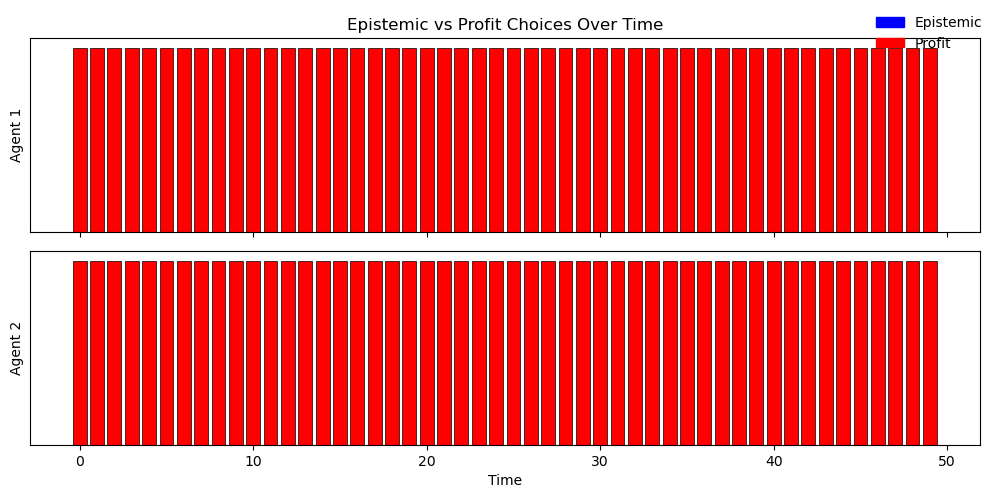

In [1544]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Convert 'Epistemic' and 'Profit' into colors
def get_colors(epistemic_choices):
    return ['blue' if choice == 'Epistemic' else 'red' for choice in epistemic_choices]

# Creazione asse temporale
time = np.arange(len(epistemic_choice1))

# Ottenere colori
colors1 = get_colors(epistemic_choice1)
colors2 = get_colors(epistemic_choice2)

# Creare il plot
fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# Agente 1
axes[0].bar(time, np.ones_like(time), color=colors1, edgecolor='black', linewidth=0.5)
axes[0].set_ylabel("Agent 1")
axes[0].set_yticks([])  # Rimuove i numeri dall'asse y
axes[0].set_title("Epistemic vs Profit Choices Over Time")

# Agente 2
axes[1].bar(time, np.ones_like(time), color=colors2, edgecolor='black', linewidth=0.5)
axes[1].set_ylabel("Agent 2")
axes[1].set_yticks([])  # Rimuove i numeri dall'asse y
axes[1].set_xlabel("Time")

# Aggiungere legenda
epistemic_patch = mpatches.Patch(color='blue', label='Epistemic')
profit_patch = mpatches.Patch(color='red', label='Profit')
fig.legend(handles=[epistemic_patch, profit_patch], loc='upper right', bbox_to_anchor=(1, 1), frameon=False)

# Miglioramenti grafici
plt.tight_layout()
plt.show()

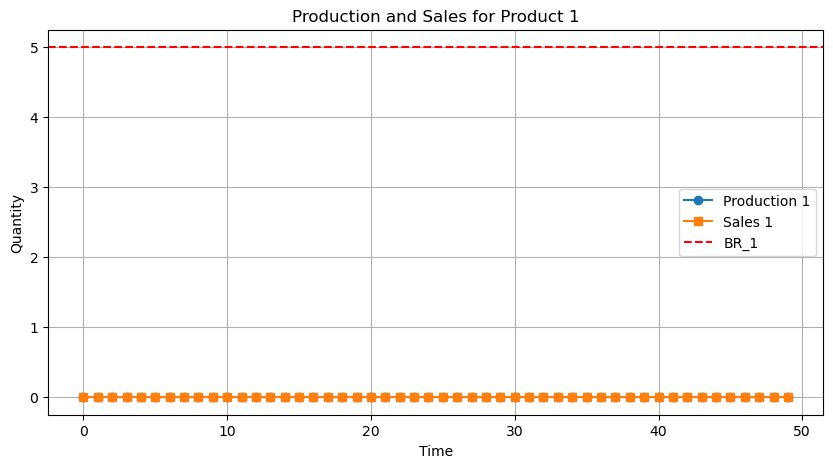

In [1545]:
# 1) Plot di prod1 e sold1 nel tempo
plt.figure(figsize=(10, 5))
plt.plot(time, prod1, label='Production 1', marker='o')
plt.plot(time, sold1, label='Sales 1', marker='s')
plt.axhline(y=BR_1, color='r', linestyle='--', label='BR_1')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.title('Production and Sales for Product 1')
plt.legend()
plt.grid()
plt.show()

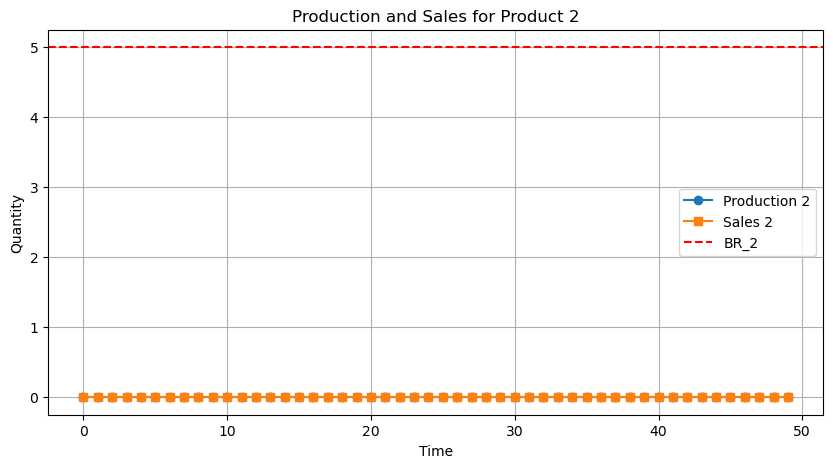

In [1546]:
# 2) Plot di prod2 e sold2 nel tempo
plt.figure(figsize=(10, 5))
plt.plot(time, prod2, label='Production 2', marker='o')
plt.plot(time, sold2, label='Sales 2', marker='s')
plt.axhline(y=BR_2, color='r', linestyle='--', label='BR_2')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.title('Production and Sales for Product 2')
plt.legend()
plt.grid()
plt.show()

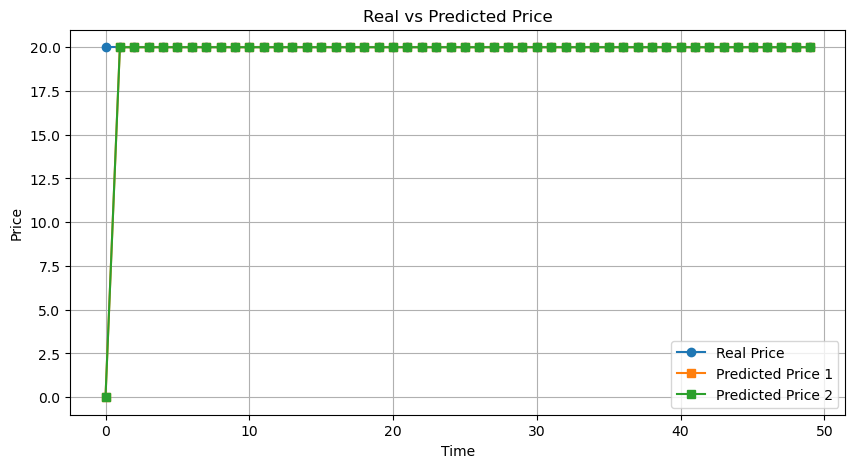

In [1547]:
# 3) Andamento di real_price e predicted_price nel tempo
plt.figure(figsize=(10, 5))
plt.plot(time, real_price, label='Real Price', marker='o')
plt.plot(time, predicted_price1, label='Predicted Price 1', marker='s')
plt.plot(time, predicted_price2, label='Predicted Price 2', marker='s')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Real vs Predicted Price')
plt.legend()
plt.grid()
plt.show()

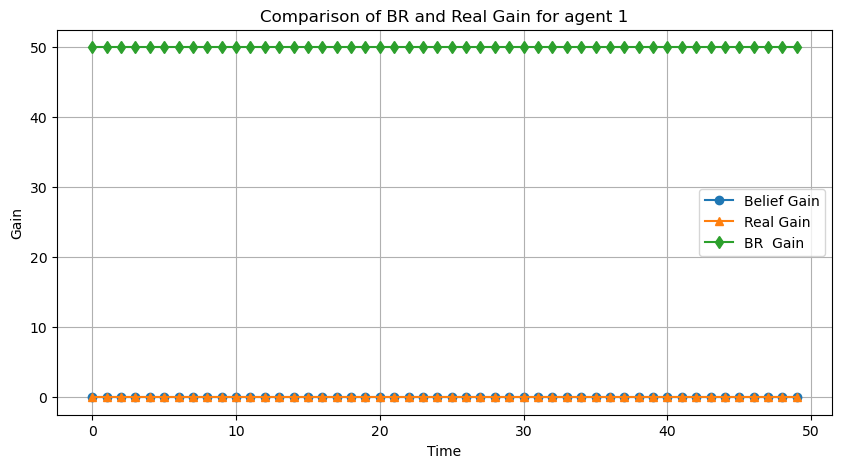

In [1548]:
# 4) Andamento di belief_gain, BR_belief_gain, real_gain, BR_real_gain nel tempo
plt.figure(figsize=(10, 5))
plt.plot(time, Belief_gain1, label='Belief Gain', marker='o')
# plt.plot(time, BR_belief_gain, label='BR Belief Gain', marker='s')
plt.plot(time, real_gain1, label='Real Gain', marker='^')
plt.plot(time, BR1_real_gain, label='BR  Gain', marker='d')
plt.xlabel('Time')
plt.ylabel('Gain')
plt.title('Comparison of BR and Real Gain for agent 1')
plt.legend()
plt.grid()
plt.show()

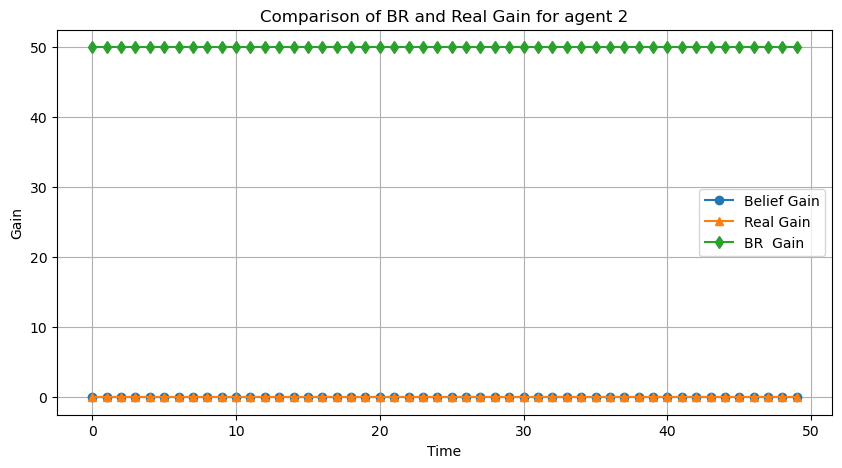

In [1549]:
plt.figure(figsize=(10, 5))
plt.plot(time, Belief_gain2, label='Belief Gain', marker='o')
# plt.plot(time, BR_belief_gain, label='BR Belief Gain', marker='s')
plt.plot(time, real_gain2, label='Real Gain', marker='^')
plt.plot(time, BR2_real_gain, label='BR  Gain', marker='d')
plt.xlabel('Time')
plt.ylabel('Gain')
plt.title('Comparison of BR and Real Gain for agent 2')
plt.legend()
plt.grid()
plt.show()